In [2]:
using CairoMakie
using Statistics
using Distributions
using Random

function lorenz96(u, F)
    len = length(u)
    du = zeros(Float64, len)
    for i = 1:len
        du[i] = (u[mod(i + 1 - 1, len) + 1] .- u[mod(i - 2 - 1, len) + 1]) .* u[mod(i - 1 - 1, len) + 1] .- u[mod(i - 1, len) + 1] .+ F
    end
    return du
end;

function rk4_step(u, dt, F)
    k1 = lorenz96(u, F)
    k2 = lorenz96(u .+ dt * k1/2.0, F)
    k3 = lorenz96(u .+ dt * k2/2.0, F)
    k4 = lorenz96(u .+ dt * k3, F)
    u_next = u .+ (dt/6.0) .* (k1 .+ 2.0 .*k2 .+ 2.0 .*k3 .+ k4)
    return u_next
end;

function solver(u0, dt, tstep, F; spin_up_time=0, add_noise=false, std=0.1)
    dus = zeros(Float64, length(u0), tstep)

    tmp_du = u0
    for t in 1:spin_up_time
        tmp_du = rk4_step(tmp_du, dt, F)
    end

    dus[:, 1] = tmp_du

    for t in 2:tstep
        if t==add_noise
            dus[:, t] = rk4_step(dus[:, t-1] + std * rand(Normal(0, 1), length(u0)), dt, F)
        else
            dus[:, t] = rk4_step(dus[:, t-1], dt, F)
        end

    end
    return dus
end;


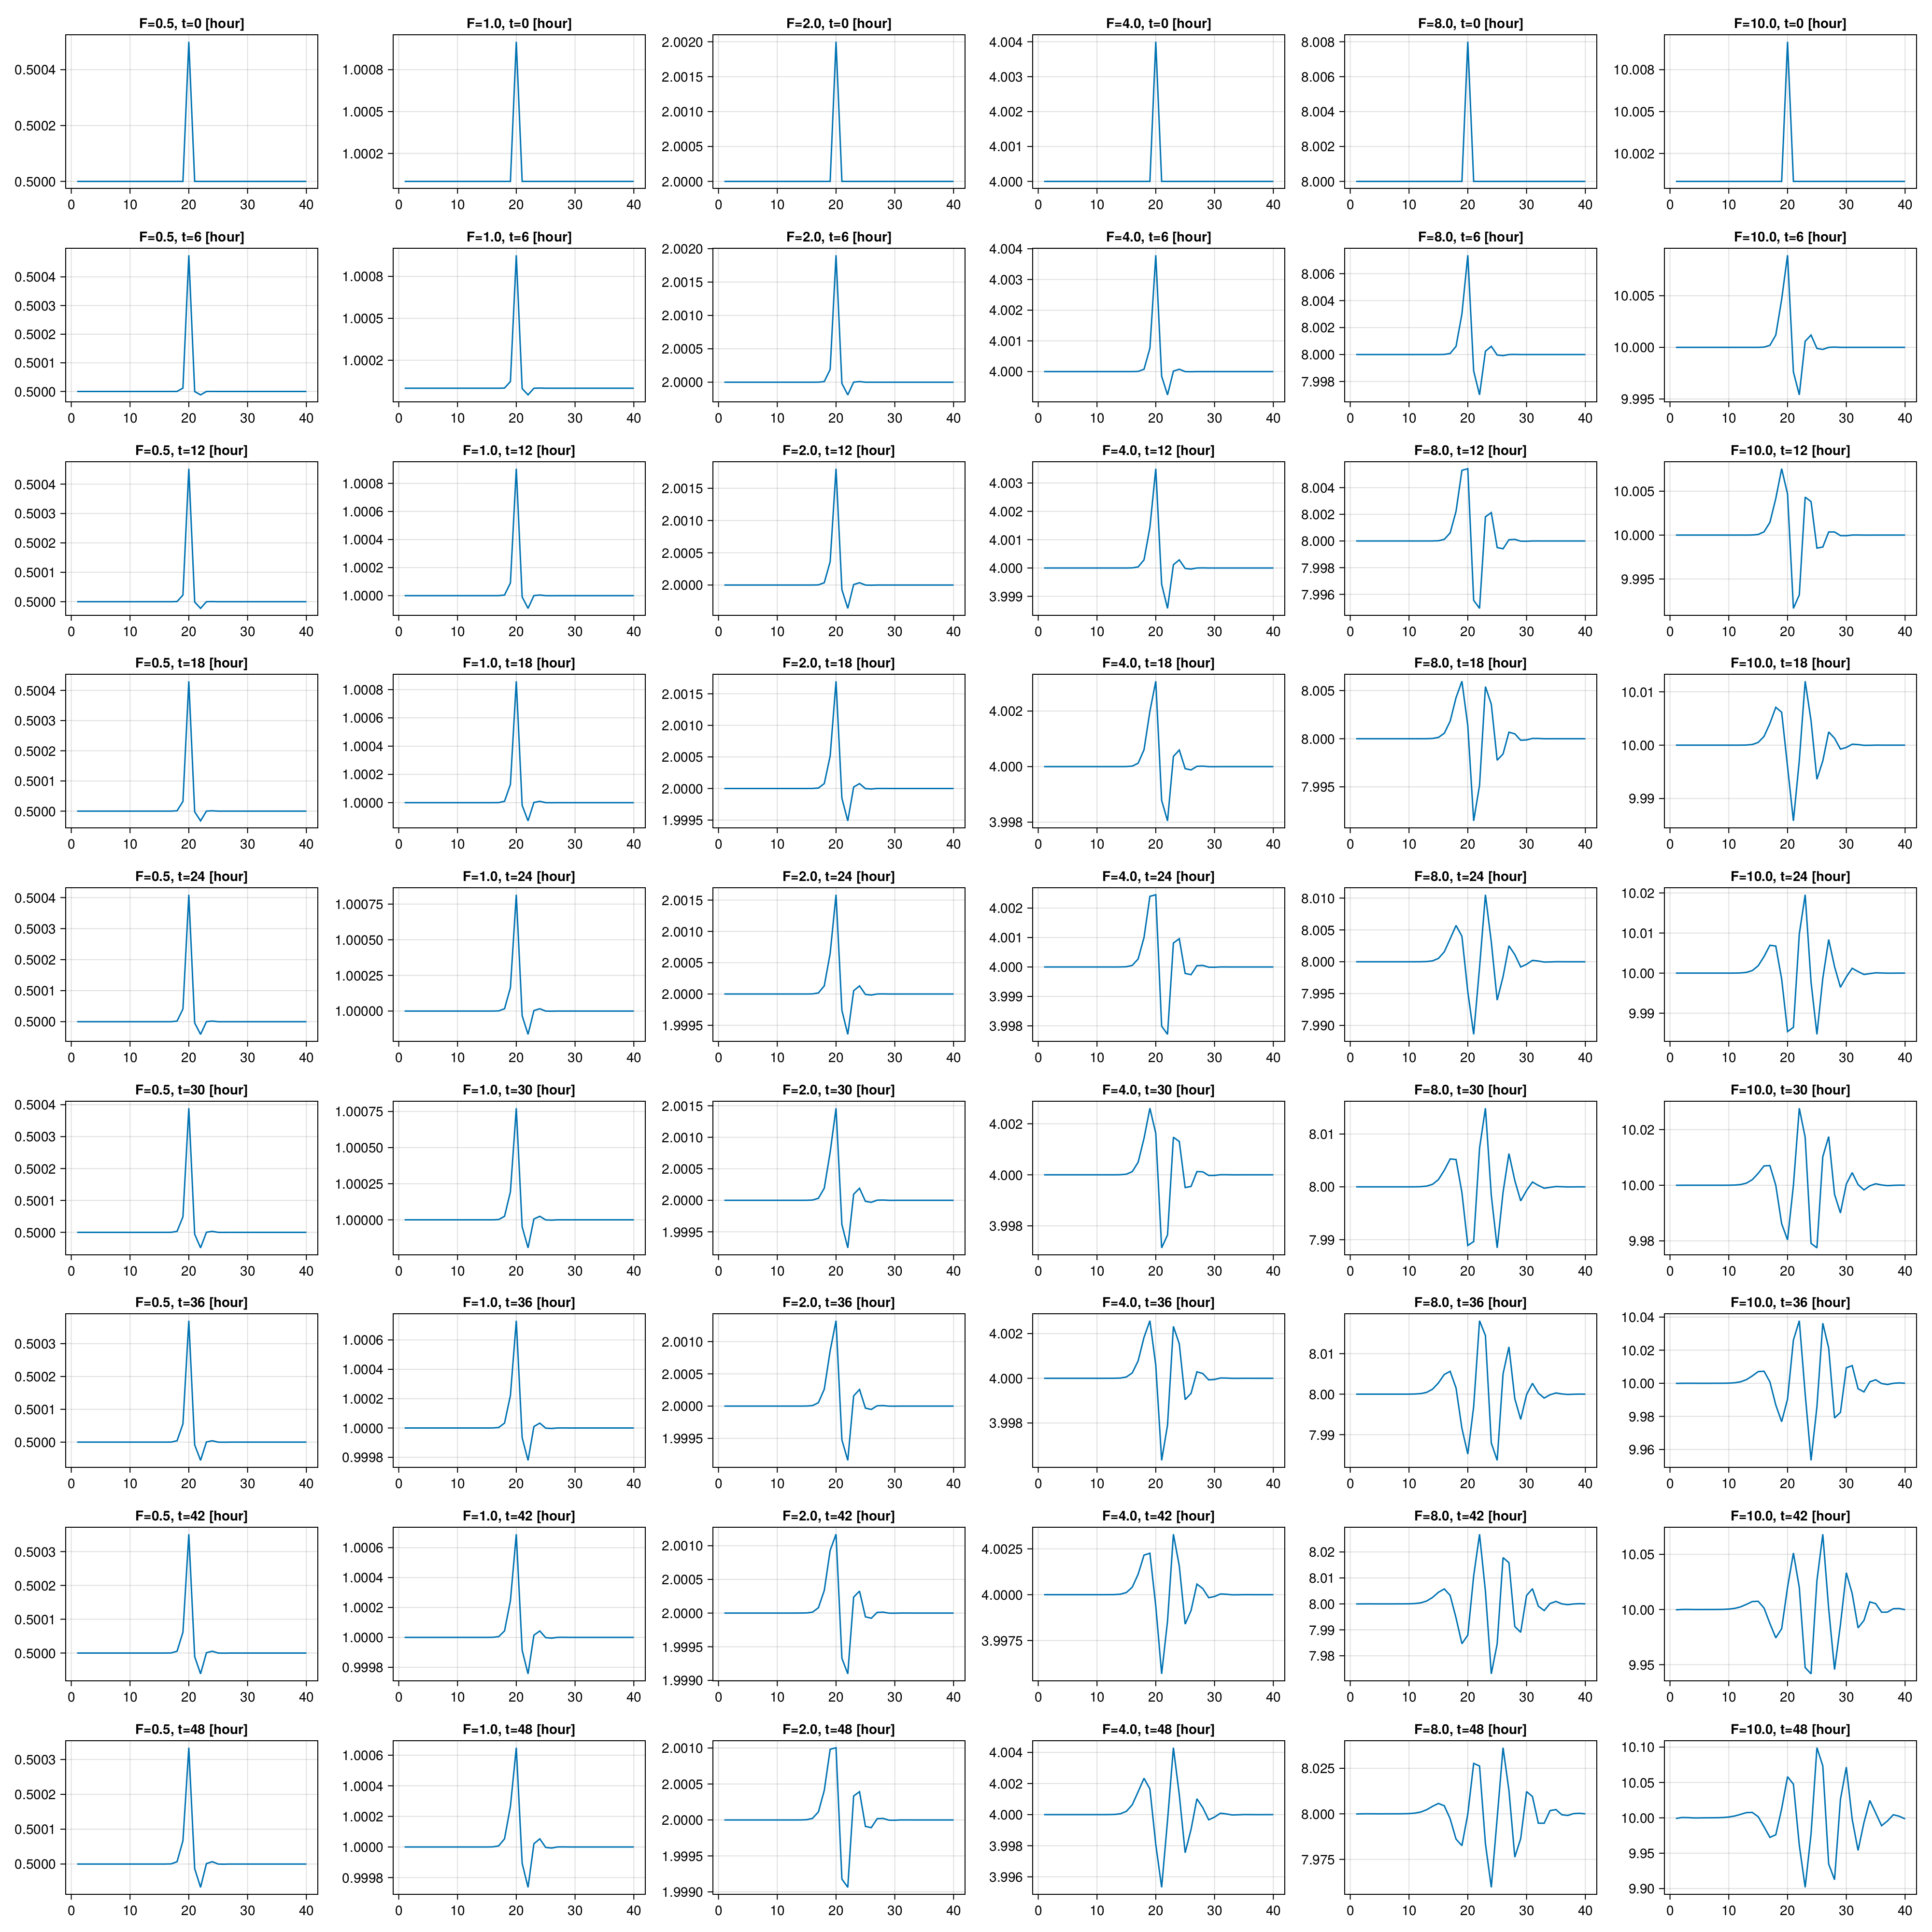

CairoMakie.Screen{IMAGE}


In [159]:
using CairoMakie

n_site = 40
# u = append!(ones(Float64, 16), [1.0001], ones(Float64, 17))
tstep = 100
dt = 0.05 # eq 6 hours

fig = Figure(size=(2000, 2000))
# fig = Figure(size=(800, 2200))

for (idx_f, f) in enumerate([0.5, 1, 2, 4, 8, 10])
    u = append!(ones(Float64, Integer((n_site/2)-1)) * f, [f * 1.001], ones(Float64, Integer(n_site/2)) * f)
    sol = solver(u, dt, tstep, f)
    # xticks=range(0, tstep, 9),
    # xminorticks=range(0, tstep, 25), xminorticksvisible=true)
    a = []
    for (idx, t) = enumerate(1:1:9)
        lt = t - 1
        lt *= 6
        ax = fig[idx, idx_f] = Axis(fig, title="F=$f, t=$lt [hour]")

        lines!(ax, range(1, n_site), sol[:, t], labels="$lt [hour]")
    end

end

display(fig)

save("save/kadai1.png", fig)

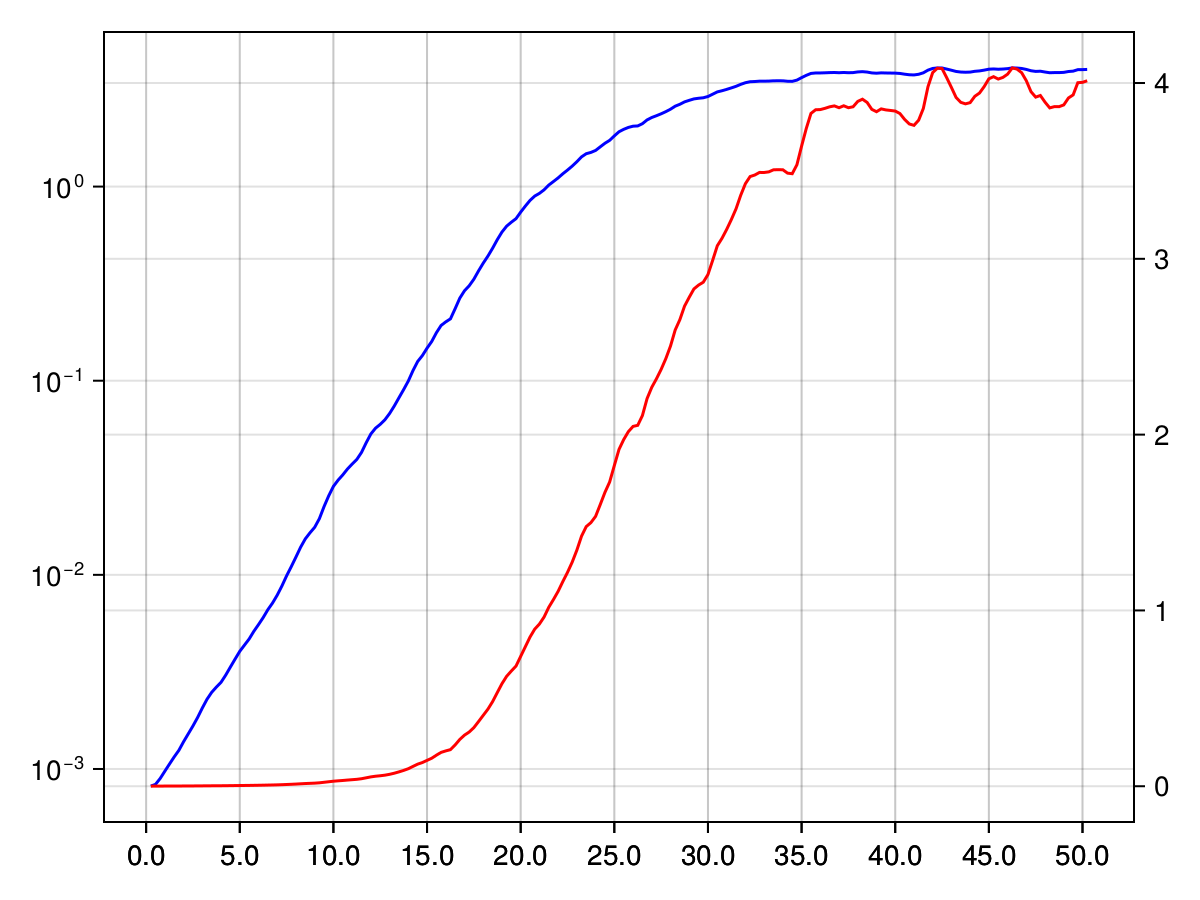

200


CairoMakie.Screen{IMAGE}


In [369]:
Random.seed!(1234)

step_as_time = 6 # 6 hours

n_site = 36
dt = 0.05 # eq 6 hours
force = 8
try_number = 1000
err_add = 0.001

# step_per_day = Integer(24 / step_as_time)
u = randn(n_site)
tstep = Integer(50*24/step_as_time) # 50 days
println(tstep)


spin_up_time = Integer(3 * 365 * 24 / step_as_time) # 3年間

errs = zeros(try_number, tstep + 1)

for s in range(1, try_number)
    # u = append!(ones(Float64, Integer((n_site/2)-1)) * force, [force * 1.001], ones(Float64, Integer(n_site/2)) * force)
    sol = solver(u, dt, s + tstep, force; spin_up_time=spin_up_time, add_noise=s, std=err_add)
    sol_ctl = solver(u, dt, s + tstep, force; spin_up_time=spin_up_time)
    err = mean.(sqrt.((sol[1, s: s + tstep] .- sol_ctl[1, s: s + tstep]).^2))
    errs[s, :] = err
end

errs = mean(errs, dims=1)

foraxishour = 20
fig = Figure()
ax1 = fig[1, 1] = Axis(fig, xticks=((0:foraxishour:tstep), string.((0:foraxishour:tstep)*step_as_time/24)); yscale=log10) # 6は一日あたりのステップ数
ax2 = fig[1, 1] = Axis(fig, xticks=((0:foraxishour:tstep), string.((0:foraxishour:tstep)*step_as_time/24)); yaxisposition = :right)
# hidespines!(ax2)
# hidexdecorations!(ax2)

lines!(ax1, range(1, tstep+1), errs[1, :], color = :blue)
lines!(ax2, range(1, tstep+1), errs[1, :], color = :red)
# lines!(sol[1, :])
# lines!(sol_ctl[1, :], labels="ctl")
display(fig)
